Align temperatures obtained with 2 different models
--



In [60]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

## 1. Load and plot original data, adjust original data for the leap year.

Load temperatures:

In [15]:
load_temp = pd.read_excel(os.path.join('/Users/anastasiagolubkova/Downloads','temperature_comparisons_hourly_mod.xlsx'),parse_dates=True) 

In [16]:
load_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32328 entries, 0 to 32327
Data columns (total 4 columns):
from    32328 non-null datetime64[ns]
to      32328 non-null datetime64[ns]
obs     32328 non-null float64
prog    32328 non-null float64
dtypes: datetime64[ns](2), float64(2)
memory usage: 1010.3 KB


In [17]:
load_temp.head(10)

,from,to,obs,prog
0,2019-01-01 00:00:00,2019-01-01 01:00:00,24.641001,0.0
1,2019-01-01 01:00:00,2019-01-01 02:00:00,24.221001,0.0
2,2019-01-01 02:00:00,2019-01-01 03:00:00,23.780001,0.0
3,2019-01-01 03:00:00,2019-01-01 04:00:00,23.889999,0.0
4,2019-01-01 04:00:00,2019-01-01 05:00:00,23.680000,0.0
5,2019-01-01 05:00:00,2019-01-01 06:00:00,23.582001,0.0
6,2019-01-01 06:00:00,2019-01-01 07:00:00,23.582001,0.0
7,2019-01-01 07:00:00,2019-01-01 08:00:00,23.805000,0.0
8,2019-01-01 08:00:00,2019-01-01 09:00:00,24.834000,0.0
9,2019-01-01 09:00:00,2019-01-01 10:00:00,25.929001,0.0


Plot observed against forecasted temperatures:

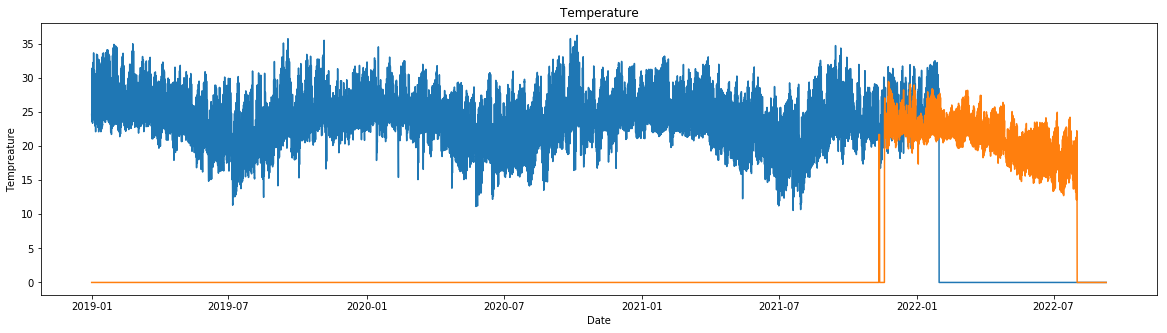

In [18]:
plt.figure(figsize=(20,5))
plt.plot(load_temp['from'], load_temp.obs)
plt.plot(load_temp['from'], load_temp.prog)
plt.xlabel('Date')
plt.ylabel('Tempreature')
plt.title('Temperature')
plt.show();

2020 was a leap year, remove 2020-02-29:

In [19]:
temp_df = load_temp;
new_values = (temp_df[temp_df['from'].dt.date == datetime.date(2020,2,29)].obs + \
 temp_df[temp_df['from'].dt.date == datetime.date(2020,2,28)].obs)/2
temp_df[temp_df['from'].dt.date == datetime.date(2020,2,28)].obs = new_values
temp_df.drop(temp_df.loc[temp_df['from'].dt.date == datetime.date(2020,2,29)].index, inplace=True)

In [20]:
temp_df.reset_index(drop=True);

Add a time axis which corresponds to the number of hours passed from the beginning of each year:

In [21]:
temp_df['year']= pd.to_datetime(temp_df['from'].dt.year.astype('str'))
temp_df['hrs'] = (temp_df['from']-temp_df['year']).astype('timedelta64[h]')

Adjustement for the leap year:

In [22]:
new_hrs = temp_df.loc[(temp_df['from'].dt.date>=datetime.date(2020,3,1)) & (temp_df['from'].dt.date<datetime.date(2021,1,1))].hrs - 24
temp_df.loc[(temp_df['from'].dt.date>=datetime.date(2020,3,1)) & (temp_df['from'].dt.date<datetime.date(2021,1,1))].hrs = new_hrs

In [23]:
temp_df.loc[(temp_df['from'].dt.date>=datetime.date(2020,3,1)) & (temp_df['from'].dt.date<datetime.date(2021,1,1)),"hrs"] = new_hrs

## 2. Align time-axes for forecasted and observed temperatures and plot the results.

Compare forecast against observed data for each year:

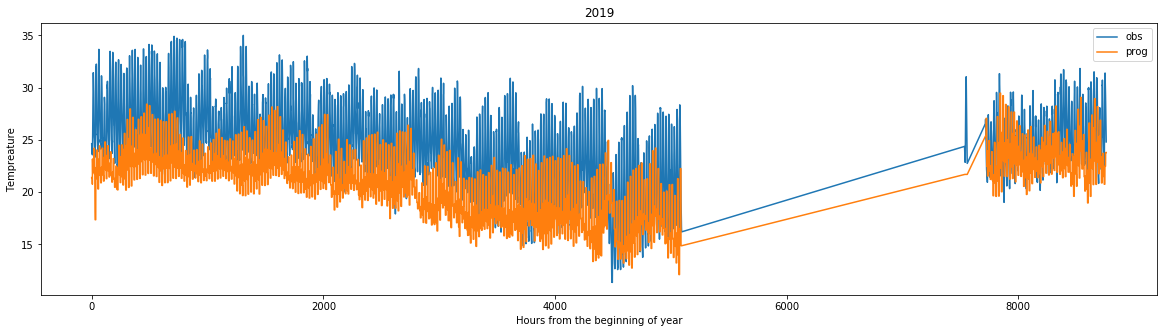

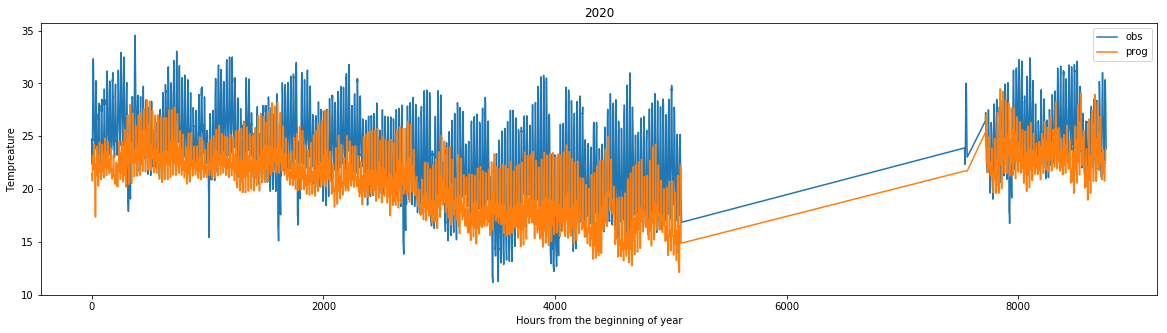

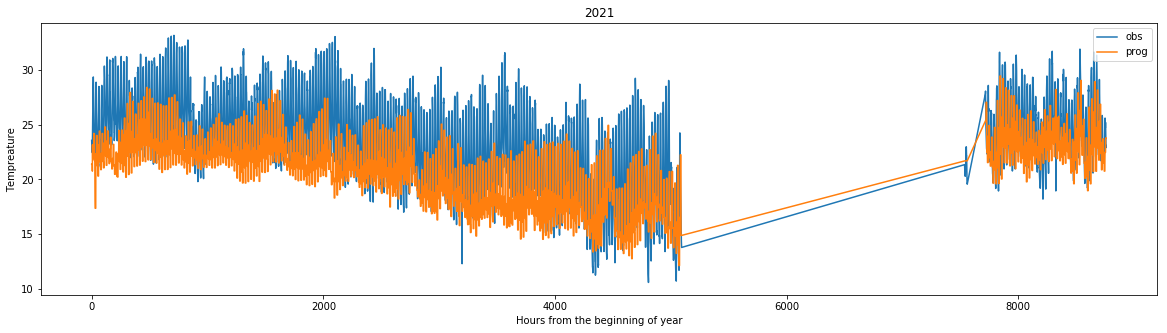

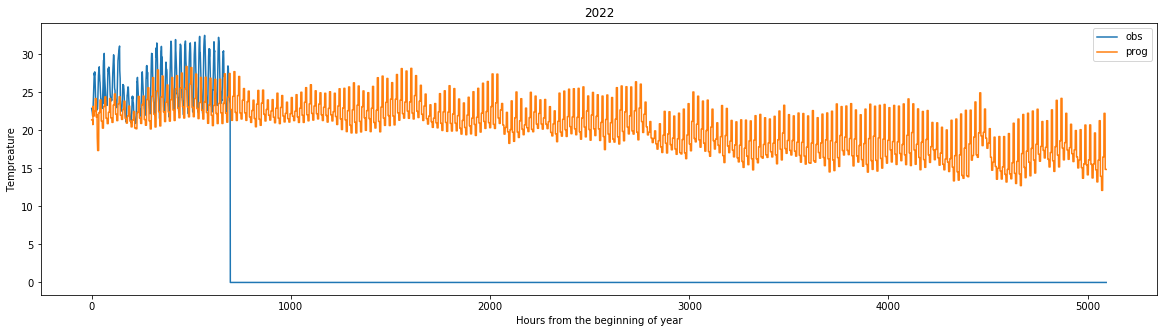

In [24]:
years = temp_df.groupby(load_temp['from'].dt.year).groups.keys()
hrs_msk = 0;
observed = 0;
forecasted = 0;

for y in years:
    prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
    obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
    if obs_df.shape[0] >= prog_df.shape[0]:
        hrs_msk = obs_df.hrs.isin(prog_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]]
        forecasted = prog_df
    else:
        hrs_msk = prog_df.hrs.isin(obs_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]]
        forecasted = prog_df.loc[prog_df.hrs[hrs_msk==True]]
    
    # Plot observed and forecasted time-series for each year
    plt.figure(figsize=(20,5))
    plt.plot(observed.hrs, observed.obs)
    plt.plot(forecasted.hrs, forecasted.prog)
    plt.xlabel('Hours from the beginning of year')
    plt.ylabel('Tempreature')
    plt.legend(loc='upper right')
    plt.title(y)
    plt.show();

Plot scatter plots for each year, add linear regression line:

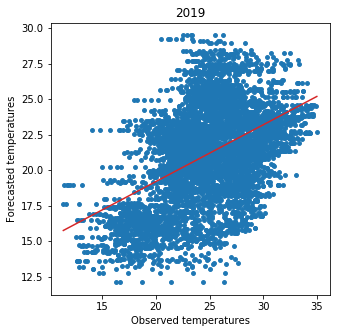

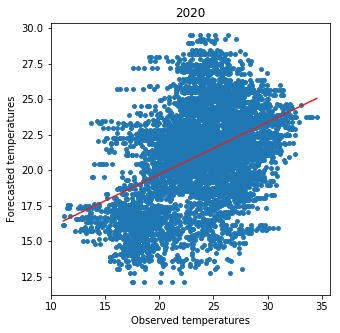

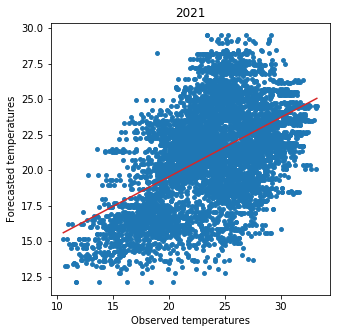

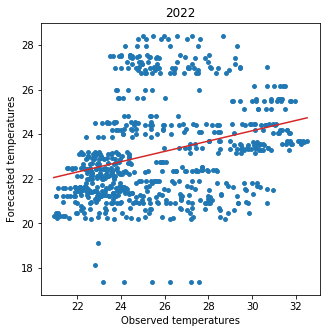

In [39]:
years = temp_df.groupby(load_temp['from'].dt.year).groups.keys()
hrs_msk = 0;
observed = 0;
forecasted = 0;

for y in years:
    prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
    obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
    if obs_df.shape[0] >= prog_df.shape[0]:
        hrs_msk = obs_df.hrs.isin(prog_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.reset_index(drop=True)
    else:
        hrs_msk = prog_df.hrs.isin(obs_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.loc[prog_df.hrs[hrs_msk==True]].reset_index(drop=True)
        
    df = pd.concat([observed.obs,forecasted.prog],axis=1)
    
    coefs = np.polyfit(df.loc[df.obs!=0].obs,df.loc[df.obs!=0].prog,1)
    # Plot observed and forecasted temperatures for each year
    plt.figure(figsize=(5,5))
    plt.scatter(df.loc[df.obs!=0].obs,df.loc[df.obs!=0].prog,s=15)
    x_values = np.linspace(df.loc[df.obs!=0].obs.min(), df.loc[df.obs!=0].obs.max(), num=100)
    y_values = np.polyval(coefs, x_values)
    plt.plot(x_values, y_values, c='C3', label='polyfit(deg=1)')
    plt.xlabel('Observed temperatures')
    plt.ylabel('Forecasted temperatures')
    plt.title(y)
    plt.show();

Compute Pearson correlation coefficient for each month of each year:

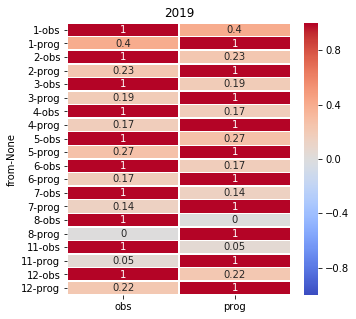

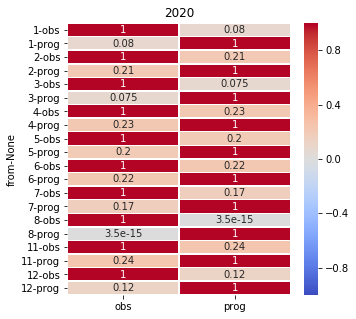

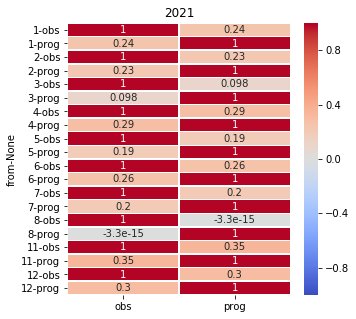

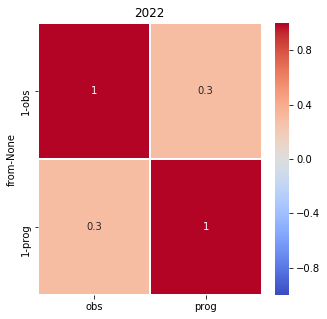

In [40]:
years = temp_df.groupby(load_temp['from'].dt.year).groups.keys()
hrs_msk = 0;
observed = 0;
forecasted = 0;

for y in years:
    prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
    obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
    if obs_df.shape[0] >= prog_df.shape[0]:
        hrs_msk = obs_df.hrs.isin(prog_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.reset_index(drop=True)
    else:
        hrs_msk = prog_df.hrs.isin(obs_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.loc[prog_df.hrs[hrs_msk==True]].reset_index(drop=True)
        
    df = pd.concat([observed['from'],observed.obs,forecasted.prog],axis=1)
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(y);
    sns.heatmap(df.loc[df.obs!=0].groupby(df['from'].dt.month).corr(), \
                vmin=-1, vmax=1, cmap="coolwarm", annot=True, linewidths=.5, ax=ax)

Visual analysis of scatter plots (with a linear regression line) and Pearson correlation coefficient indicate that there is a weak linear relation between the forecasted and observed temperatures. Moreover, on the scatter plots one can see that the same forecasted temperatures correspond to the different observed results which could be the result of measurements' error.

Compute the differences and plot the histograms. If the difference between the forecast and observations is relatively constance, a narrow normal distribution is expected:

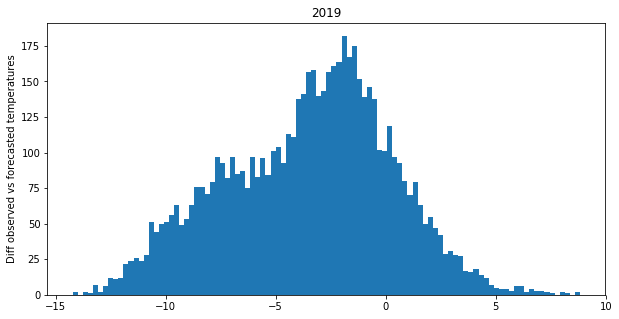

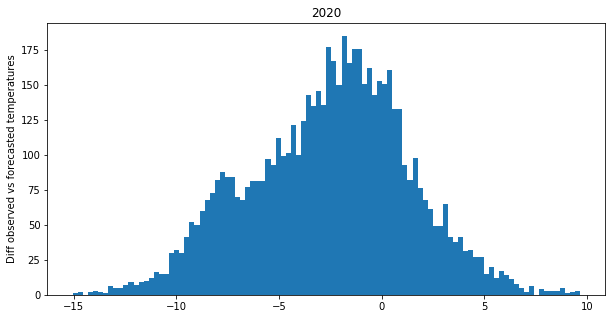

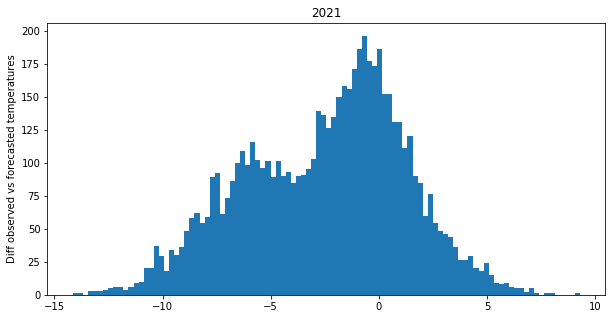

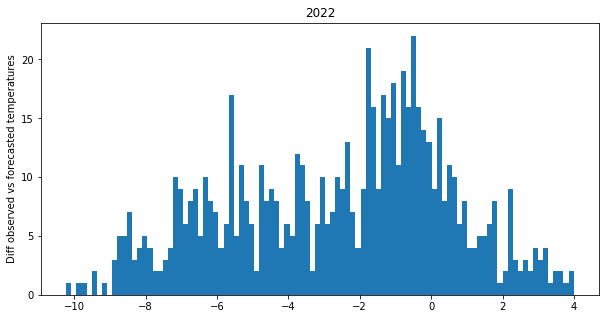

In [42]:
years = temp_df.groupby(load_temp['from'].dt.year).groups.keys()
hrs_msk;
observed = 0;
forecasted = 0;

for y in years:
    prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
    obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
    if obs_df.shape[0] >= prog_df.shape[0]:
        hrs_msk = obs_df.hrs.isin(prog_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.reset_index(drop=True)
    else:
        hrs_msk = prog_df.hrs.isin(obs_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.loc[prog_df.hrs[hrs_msk==True]].reset_index(drop=True)
        
    df = pd.concat([observed.obs,forecasted.prog],axis=1)
    dif = df.loc[df.obs!=0].prog - df.loc[df.obs!=0].obs
    plt.figure(figsize=(10,5))
    plt.hist(dif, bins=100)
    plt.ylabel('Diff observed vs forecasted temperatures')
    plt.title(y)
    plt.show();

Difference between forecasted and observed temperatures is not constant.

For year 2019, analyze linear relations depending on the temperature range:

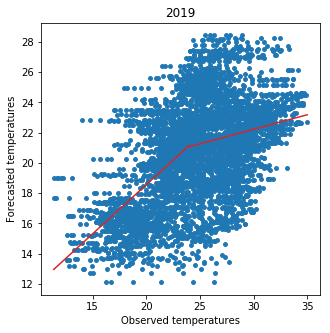

In [43]:
hrs_msk = 0;
observed = 0;
forecasted = 0;
t = 24;
y = 2019;

prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
if obs_df.shape[0] >= prog_df.shape[0]:
    hrs_msk = obs_df.hrs.isin(prog_df.hrs)
    observed_df = obs_df.loc[obs_df.hrs[hrs_msk==True]]
    forecasted_df = prog_df
else:
    hrs_msk = prog_df.hrs.isin(obs_df.hrs)
    observed_df = obs_df.loc[obs_df.hrs[hrs_msk==True]]
    forecasted_df = prog_df.loc[prog_df.hrs[hrs_msk==True]]
    
df = observed_df
df["forecast"] = forecasted_df.prog

coefs_low = np.polyfit(df.loc[df.obs<t].dropna().obs,df.loc[df.obs<t].dropna().forecast,1)
coefs_high = np.polyfit(df.loc[df.obs>=t].dropna().obs,df.loc[df.obs>=t].dropna().forecast,1)
    
plt.figure(figsize=(5,5))
plt.scatter(df.obs,df.forecast,s=15)
x_values_low = np.linspace(df.loc[df.obs<t].obs.min(), df.loc[df.obs<t].obs.max(), num=100)
y_values_low = np.polyval(coefs_low, x_values_low)
plt.plot(x_values_low, y_values_low, c='C3')
x_values_high = np.linspace(df.loc[df.obs>=t].obs.min(), df.loc[df.obs>=t].obs.max(), num=100)
y_values_high = np.polyval(coefs_high, x_values_high)
plt.plot(x_values_high, y_values_high, c='C3')
plt.xlabel('Observed temperatures')
plt.ylabel('Forecasted temperatures')
plt.title(y)
plt.show();


For a selected year, two linear regressions for temperatures below and above 24C don't provide a good representation of observed phenomena.

## 3. Smooth data with moving average and repeate analysis of linear relations.

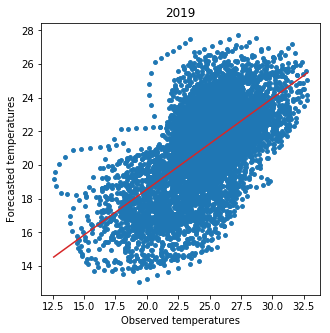

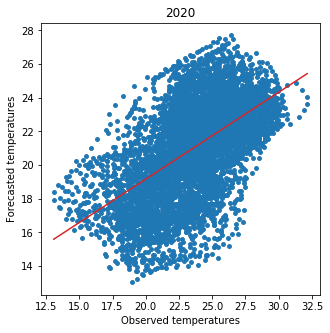

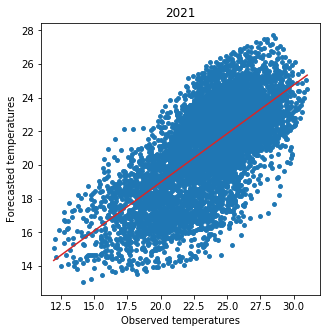

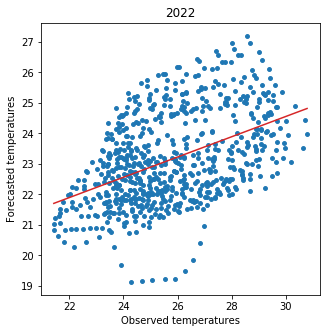

In [45]:
years = temp_df.groupby(load_temp['from'].dt.year).groups.keys()
hrs_msk = 0;
observed = 0;
forecasted = 0;
window_size = 12;

for y in years:
    prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
    obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
    if obs_df.shape[0] >= prog_df.shape[0]:
        hrs_msk = obs_df.hrs.isin(prog_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.reset_index(drop=True)
    else:
        hrs_msk = prog_df.hrs.isin(obs_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.loc[prog_df.hrs[hrs_msk==True]].reset_index(drop=True)
    
    df = pd.concat([observed.obs,forecasted.prog],axis=1)
    o = df.loc[df.obs!=0].obs.rolling(window = window_size).mean().dropna()
    f = df.loc[df.obs!=0].prog.rolling(window = window_size).mean().dropna()
    
    coefs = np.polyfit(o,f,1)
    # Plot observed and forecasted temperatures for each year
    plt.figure(figsize=(5,5))
    plt.scatter(o,f,s=15)
    x_values = np.linspace(o.min(), o.max(), num=100)
    y_values = np.polyval(coefs, x_values)
    plt.plot(x_values, y_values, c='C3', label='polyfit(deg=1)')
    plt.xlabel('Observed temperatures')
    plt.ylabel('Forecasted temperatures')
    plt.title(y)
    plt.show();

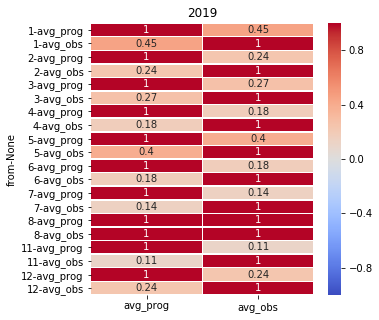

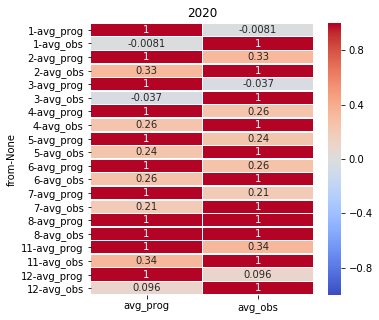

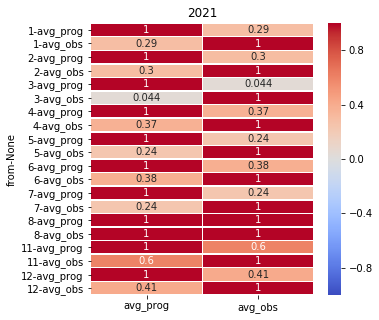

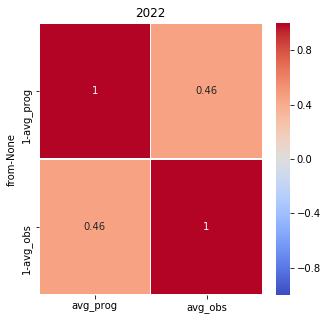

In [46]:
years = temp_df.groupby(load_temp['from'].dt.year).groups.keys()
hrs_msk = 0;
observed = 0;
forecasted = 0;

for y in years:
    prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
    obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
    if obs_df.shape[0] >= prog_df.shape[0]:
        hrs_msk = obs_df.hrs.isin(prog_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.reset_index(drop=True)
    else:
        hrs_msk = prog_df.hrs.isin(obs_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.loc[prog_df.hrs[hrs_msk==True]].reset_index(drop=True)
        
    df = pd.concat([observed['from'],observed.obs,forecasted.prog],axis=1)
    df["avg_obs"] = df.loc[df.obs!=0].obs.rolling(window=window_size).mean()
    df["avg_prog"] = df.loc[df.obs!=0].prog.rolling(window=window_size).mean()
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(y);
    sns.heatmap(df[{"from","avg_obs","avg_prog"}].dropna().groupby(df['from'].dt.month).corr(), \
                vmin=-1, vmax=1, cmap="coolwarm", annot=True, linewidths=.5, ax=ax)

When data is smoothed with moving average (12 units), linear relation between forecasted and observed temperatures is stronger than on the raw data.

## 4. Remove outliers from the observations.

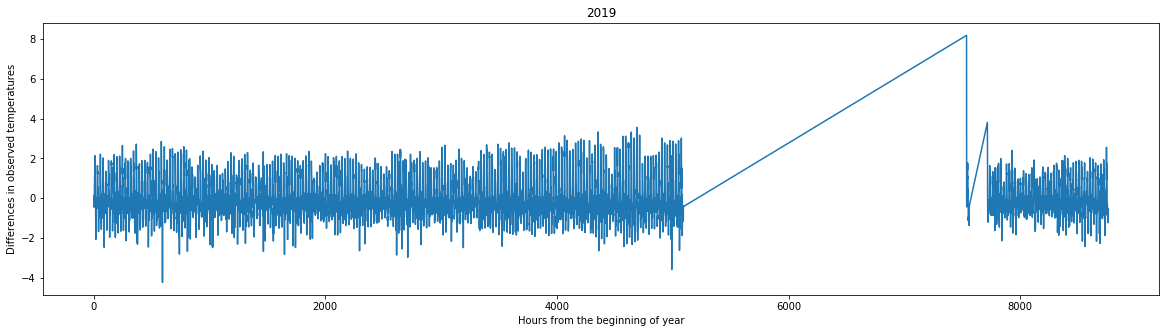

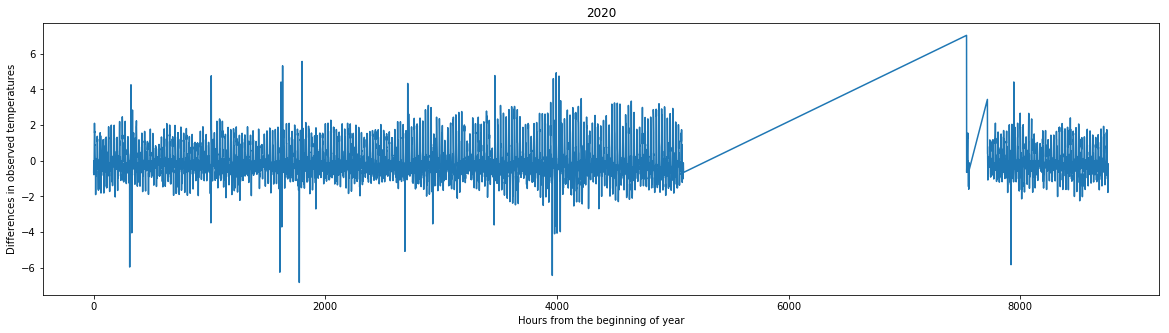

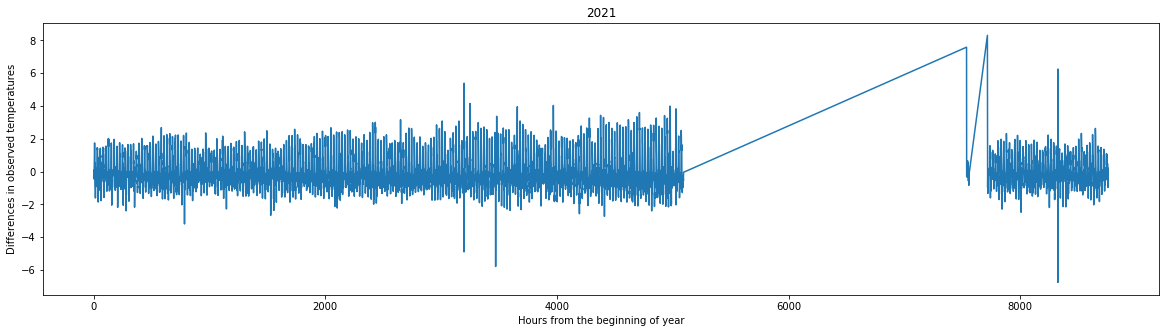

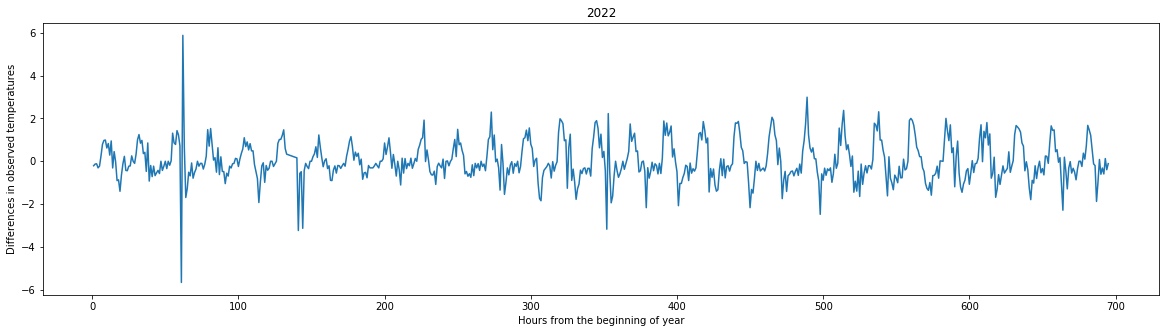

In [56]:
years = temp_df.groupby(load_temp['from'].dt.year).groups.keys()
hrs_msk = 0;
observed = 0;
forecasted = 0;

for y in years:
    prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
    obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
    if obs_df.shape[0] >= prog_df.shape[0]:
        hrs_msk = obs_df.hrs.isin(prog_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]]
        forecasted = prog_df
    else:
        hrs_msk = prog_df.hrs.isin(obs_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]]
        forecasted = prog_df.loc[prog_df.hrs[hrs_msk==True]]
    
    # Plot observed and forecasted time-series for each year
    plt.figure(figsize=(20,5))
    plt.plot(observed.loc[observed.obs!=0].hrs, observed.loc[observed.obs!=0].obs.diff(periods=1))
    plt.xlabel('Hours from the beginning of year')
    plt.ylabel('Differences in observed temperatures')
    plt.title(y)
    plt.show();

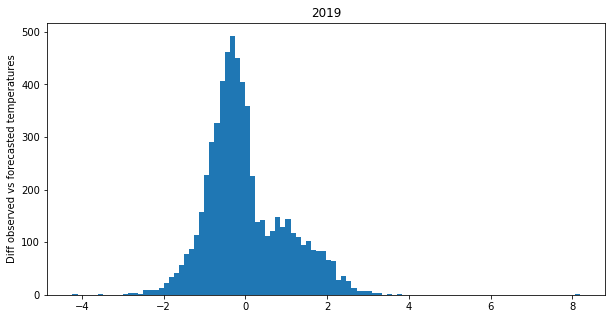

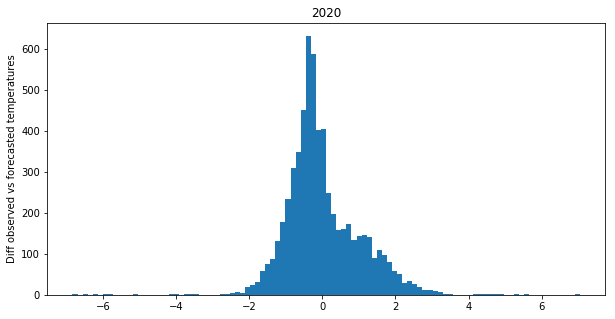

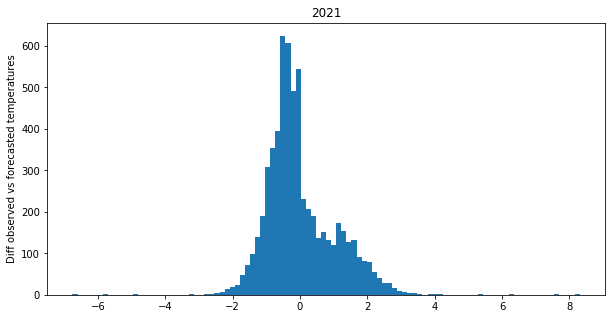

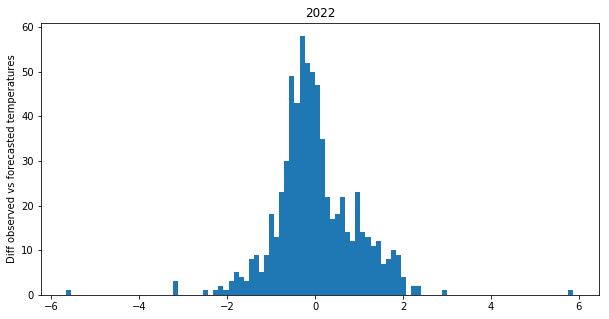

In [57]:
years = temp_df.groupby(load_temp['from'].dt.year).groups.keys()
hrs_msk;
observed = 0;
forecasted = 0;

for y in years:
    prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
    obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
    if obs_df.shape[0] >= prog_df.shape[0]:
        hrs_msk = obs_df.hrs.isin(prog_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.reset_index(drop=True)
    else:
        hrs_msk = prog_df.hrs.isin(obs_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.loc[prog_df.hrs[hrs_msk==True]].reset_index(drop=True)
        
    df = pd.concat([observed.obs,forecasted.prog],axis=1)
    dif = df.loc[df.obs!=0].obs.diff(periods=1)
    plt.figure(figsize=(10,5))
    plt.hist(dif, bins=100)
    plt.ylabel('Diff in observed temperatures')
    plt.title(y)
    plt.show();

Remove outliers which lie outside of range p75 + 1.5*IQR:

34.944750070571885
14.544750452041587


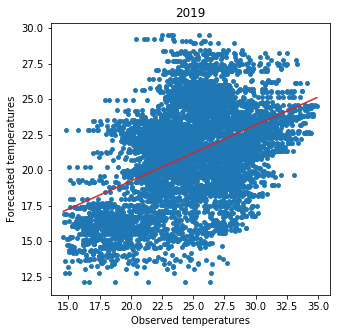

34.0528745651244
13.355875968933194


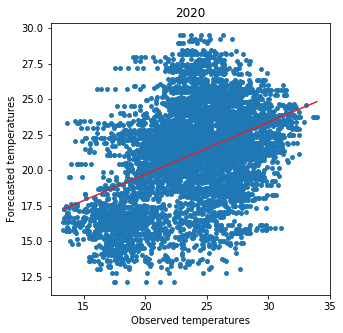

34.49187531471256
12.908874811172467


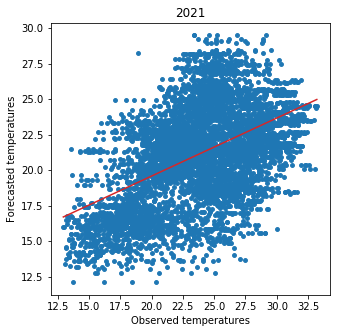

34.842375000000004
16.437375


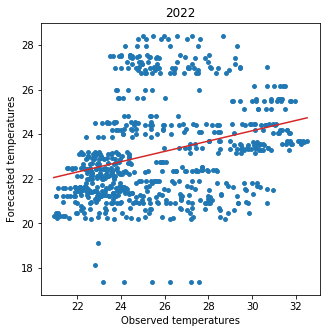

In [73]:
years = temp_df.groupby(load_temp['from'].dt.year).groups.keys()
hrs_msk = 0;
observed = 0;
forecasted = 0;
window_size = 12;

for y in years:
    prog_df = temp_df.loc[temp_df.prog!=0].sort_values(by='hrs').reset_index(drop=True)
    obs_df = temp_df.loc[temp_df['from'].dt.year==y].reset_index(drop=True)
    
    if obs_df.shape[0] >= prog_df.shape[0]:
        hrs_msk = obs_df.hrs.isin(prog_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.reset_index(drop=True)
    else:
        hrs_msk = prog_df.hrs.isin(obs_df.hrs)
        observed = obs_df.loc[obs_df.hrs[hrs_msk==True]].reset_index(drop=True)
        forecasted = prog_df.loc[prog_df.hrs[hrs_msk==True]].reset_index(drop=True)
    
    df = pd.concat([observed.obs,forecasted.prog],axis=1)
    iqr = scipy.stats.iqr(df.loc[df.obs!=0].obs)
    p25 = np.percentile(df.loc[df.obs!=0].obs,25)
    p75 = np.percentile(df.loc[df.obs!=0].obs,75)
    upper_threshold = p75 + 1.5*iqr
    lower_threshold = p25 - 1.5*iqr
    
    o = df.loc[(df.obs!=0) & (df.obs>=lower_threshold) & (df.obs<upper_threshold)].obs
    f = df.loc[(df.obs!=0) & (df.obs>=lower_threshold) & (df.obs<upper_threshold)].prog
    
    coefs = np.polyfit(o,f,1)
    # Plot observed and forecasted temperatures for each year
    plt.figure(figsize=(5,5))
    plt.scatter(o,f,s=15)
    x_values = np.linspace(o.min(), o.max(), num=100)
    y_values = np.polyval(coefs, x_values)
    plt.plot(x_values, y_values, c='C3', label='polyfit(deg=1)')
    plt.xlabel('Observed temperatures')
    plt.ylabel('Forecasted temperatures')
    plt.title(y)
    plt.show();